Handwritten Digits Generator With a GAN

https://realpython.com/generative-adversarial-networks/

In [1]:
import torch
from torch import nn

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.manual_seed(111)

In [5]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [6]:
device

device(type='cpu')

Prepare the training data

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [8]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

PyTorch data loader

In [9]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle = True
)

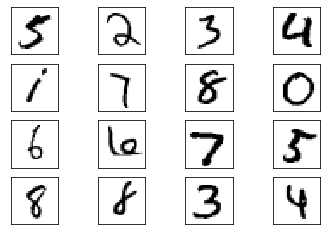

In [10]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28,28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Implementing the Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output        

In [12]:
discriminator = Discriminator().to(device=device)

Implementing the Generator

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output    

In [14]:
generator = Generator().to(device=device)

Training the Models

In [15]:
lr = 0.0005
num_epochs = 50
loss_function = nn.BCELoss()

In [16]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimzier_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Training Loop

In [17]:
for epoch in range(num_epochs):
    for n,(real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimzier_generator.step()
        
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D. {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G. {loss_generator}")

Epoch: 0 Loss D. 0.019823338836431503
Epoch: 0 Loss G. 5.8210673332214355
Epoch: 1 Loss D. 0.572878360748291
Epoch: 1 Loss G. 0.9533067345619202
Epoch: 2 Loss D. 0.6351348757743835
Epoch: 2 Loss G. 1.099226713180542
Epoch: 3 Loss D. 0.6745572686195374
Epoch: 3 Loss G. 0.7038859128952026
Epoch: 4 Loss D. 0.630683958530426
Epoch: 4 Loss G. 0.7374206185340881
Epoch: 5 Loss D. 0.6760937571525574
Epoch: 5 Loss G. 0.6911845207214355
Epoch: 6 Loss D. 0.6925050020217896
Epoch: 6 Loss G. 0.6902512311935425
Epoch: 7 Loss D. 0.6931874752044678
Epoch: 7 Loss G. 0.6916202306747437
Epoch: 8 Loss D. 0.692099928855896
Epoch: 8 Loss G. 0.6941457986831665
Epoch: 9 Loss D. 0.6945544481277466
Epoch: 9 Loss G. 0.6941748857498169
Epoch: 10 Loss D. 0.6923317909240723
Epoch: 10 Loss G. 0.6936473250389099
Epoch: 11 Loss D. 0.6934249401092529
Epoch: 11 Loss G. 0.6941923499107361
Epoch: 12 Loss D. 0.6930896043777466
Epoch: 12 Loss G. 0.6934677362442017
Epoch: 13 Loss D. 0.6940011382102966
Epoch: 13 Loss G. 0.693

Checking samples generated by GAN

In [18]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

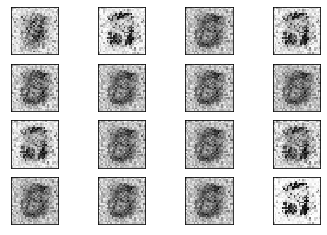

In [19]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28,28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])